### This notebook is to be used for testing and research on implementation of the TimesFM model. The actual production code is exclusively placed in .py files

In [1]:
import pandas as pd
import requests as r
from datetime import *     
import numpy as np
import os
import sys

In [2]:
sys.path.append(os.path.abspath('..'))

In [3]:
from data_utils.DataLoader import DataLoader

/opt/anaconda3/envs/SecooraVenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv('../data/test_data.csv')
df = df.iloc[:, [0, 1]].reset_index(drop=True)
df.columns = ["time", "result"]
df = df.drop(0, axis=0)
df

,time,result
1,2024-12-25T17:50:10.81222Z,-2.098
2,2024-12-25T17:55:19.800911Z,-2.064
3,2024-12-25T18:00:34.410826Z,-2.036
4,2024-12-25T18:05:43.303884Z,-2.017
5,2024-12-25T18:10:57.930353Z,-2.001
...,...,...
647,2024-12-28T05:20:38.736164Z,-2.928
648,2024-12-28T05:21:05.116032Z,-2.927
649,2024-12-28T05:21:32.13423Z,-2.925
650,2024-12-28T05:26:45.716006Z,-2.911


In [5]:
df = DataLoader.transform_data(df)
df = DataLoader.order_df(df)
df = df.dropna()
df

,year,month,day,day_of_week,hour,minute,second,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,result
4,2024,12,25,2,18,5,43,-1.000000,-1.836970e-16,0.974928,-0.222521,-2.449294e-16,1.0,-2.036,-2.064,-2.098,-2.039000,0.023643,-2.017
5,2024,12,25,2,18,10,57,-1.000000,-1.836970e-16,0.974928,-0.222521,-2.449294e-16,1.0,-2.017,-2.036,-2.064,-2.018000,0.017521,-2.001
6,2024,12,25,2,18,16,13,-1.000000,-1.836970e-16,0.974928,-0.222521,-2.449294e-16,1.0,-2.001,-2.017,-2.036,-2.000333,0.017010,-1.983
7,2024,12,25,2,18,21,27,-1.000000,-1.836970e-16,0.974928,-0.222521,-2.449294e-16,1.0,-1.983,-2.001,-2.017,-1.978000,0.025865,-1.95
8,2024,12,25,2,18,26,36,-1.000000,-1.836970e-16,0.974928,-0.222521,-2.449294e-16,1.0,-1.95,-1.983,-2.001,-1.948667,0.035019,-1.913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,2024,12,28,5,5,20,38,0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,-2.93,-2.932,-2.932,-2.930000,0.002000,-2.928
648,2024,12,28,5,5,21,5,0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,-2.928,-2.93,-2.932,-2.928333,0.001528,-2.927
649,2024,12,28,5,5,21,32,0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,-2.927,-2.928,-2.93,-2.926667,0.001528,-2.925
650,2024,12,28,5,5,26,45,0.965926,2.588190e-01,-0.974928,-0.222521,-2.449294e-16,1.0,-2.925,-2.927,-2.928,-2.921000,0.008718,-2.911


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last timestep output
        out = self.fc(out)
        return out

In [8]:
X = df.drop(columns=['result']).values
y = df['result'].values

In [9]:
sequence_length = 3

def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, sequence_length)

# Manual train-test split
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [10]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
input_size = X_seq.shape[2]
hidden_size = 64
num_layers = 2

In [12]:
LSTM_model = LSTMModel(input_size, hidden_size, num_layers)

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)

In [14]:
num_epochs = 50

for epoch in range(num_epochs):
    LSTM_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = LSTM_model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

Epoch [10/50], Loss: 2.9459
Epoch [20/50], Loss: 2.9460
Epoch [30/50], Loss: 5.6338
Epoch [40/50], Loss: 2.9370
Epoch [50/50], Loss: 2.9350


## TimesFM Testing

In [15]:
%pip install torch transformers accelerate

Note: you may need to restart the kernel to use updated packages.


In [16]:
%pip install --upgrade --pre transformers
%pip install git+https://github.com/huggingface/transformers.git

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/huggingface/transformers.git to /private/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/pip-req-build-8wbraiwi
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /private/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/pip-req-build-8wbraiwi
  Resolved https://github.com/huggingface/transformers.git to commit d231f5a7d4d110fffe91ba31b4995c8574036c14
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [17]:
df_1 = pd.read_csv("../data/historical_data_2023.csv", parse_dates=["time"])
df_1 = df_1.sort_values("time").reset_index(drop=True)

df_2 = pd.read_csv("../data/historical_data_2024.csv", parse_dates=["time"])
df_2 = df_2.sort_values("time").reset_index(drop=True)

df_3 = pd.read_csv("../data/historical_data_2025.csv", parse_dates=["time"])
df_3 = df_3.sort_values("time").reset_index(drop=True)

In [18]:
df_3

,time,result
0,2025-01-01 00:02:24.356467+00:00,-1.577
1,2025-01-01 00:07:38.158235+00:00,-1.556
2,2025-01-01 00:12:46.919872+00:00,-1.536
3,2025-01-01 00:18:00.670455+00:00,-1.509
4,2025-01-01 00:23:09.592430+00:00,-1.483
...,...,...
17027,2025-04-29 23:29:25.395409+00:00,-1.906
17028,2025-04-29 23:34:33.795148+00:00,-1.839
17029,2025-04-29 23:39:42.345197+00:00,-1.776
17030,2025-04-29 23:49:59.391218+00:00,-1.657


In [19]:
import matplotlib.pyplot as plt

def plot_series(timestamps, values, title="Time Series", xlabel="Time", ylabel="Value", figsize=(10, 4)):
    plt.figure(figsize=figsize)
    plt.plot(timestamps, values, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


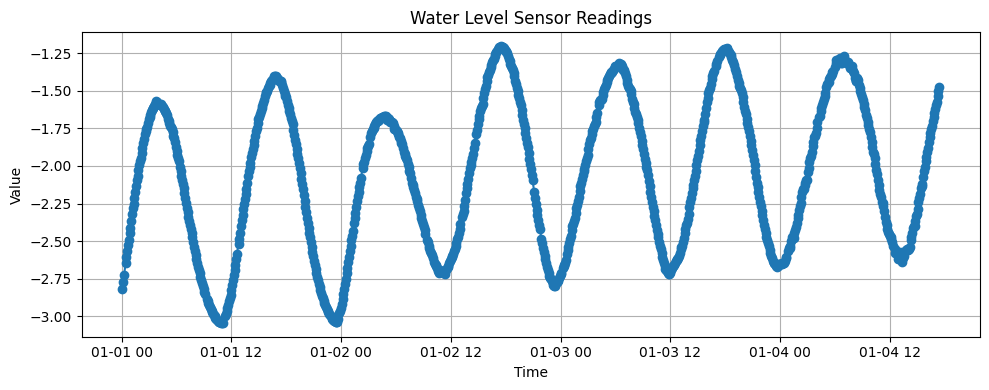

In [20]:
plot_series(df_2["time"][0:1000], df_2["result"][0:1000], title="Water Level Sensor Readings")

In [21]:
data = pd.concat([df_1, df_2, df_3], ignore_index=True)
data

,time,result
0,2023-03-14 17:17:24.631000+00:00,-0.516
1,2023-03-14 17:17:49.049000+00:00,-0.523
2,2023-03-14 17:18:14.053000+00:00,-0.533
3,2023-03-14 17:23:25.495000+00:00,-1.305
4,2023-03-14 17:28:33.261000+00:00,-1.290
...,...,...
146742,2025-04-29 23:29:25.395409+00:00,-1.906
146743,2025-04-29 23:34:33.795148+00:00,-1.839
146744,2025-04-29 23:39:42.345197+00:00,-1.776
146745,2025-04-29 23:49:59.391218+00:00,-1.657


In [22]:
first_match = data.loc[data["time"].astype(str).str.contains("2025-01-03")].iloc[0]
first_match

time      2025-01-03 00:02:47.326959+00:00
result                              -2.211
Name: 130254, dtype: object

In [23]:
data = data[0:130254]
data

,time,result
0,2023-03-14 17:17:24.631000+00:00,-0.516
1,2023-03-14 17:17:49.049000+00:00,-0.523
2,2023-03-14 17:18:14.053000+00:00,-0.533
3,2023-03-14 17:23:25.495000+00:00,-1.305
4,2023-03-14 17:28:33.261000+00:00,-1.290
...,...,...
130249,2025-01-02 23:36:43.524793+00:00,-2.497
130250,2025-01-02 23:41:55.893144+00:00,-2.440
130251,2025-01-02 23:47:04.485416+00:00,-2.379
130252,2025-01-02 23:52:18.788289+00:00,-2.321


In [24]:
series = data["result"].to_numpy(dtype="float32")

In [25]:
from torch.utils.data import Dataset

In [37]:
class TimeSeriesDataset(Dataset):

    def __init__(self, series: np.ndarray, context_len: int, horizon_len: int, freq: int):

        n = len(series) - context_len - horizon_len + 1
        self.past = torch.empty((n, context_len), dtype=torch.float32)
        self.future = torch.empty((n, horizon_len), dtype=torch.float32)
        self.freqs = torch.full((n,), freq, dtype=torch.long)

        for i in range(n):
            self.past[i] = torch.from_numpy(series[i : i + context_len])
            self.future[i] = torch.from_numpy(series[i + context_len : i + context_len + horizon_len])

    def __len__(self):
        return self.past.size(0)
    
    def __getitem__(self, idx):
        return {
            "past_values": self.past[idx],
            "freq": self.freqs[idx],
            "future_values": self.future[idx]

        }

In [38]:
from dateutil.parser import isoparse

context_len = 512 
horizon_len = 128
freq = 0 

N = len(series)
validation_frac = 0.15
test_frac = 0.15 

train_end = int(N * (1 - validation_frac - test_frac))
validation_end = int(N * (1 - test_frac))

train_series = series[:train_end]
validation_series = series[train_end - context_len : validation_end]
test_series = series[validation_end - context_len : ]

train_ds = TimeSeriesDataset(train_series, context_len, horizon_len, freq)
validation_ds = TimeSeriesDataset(validation_series, context_len, horizon_len, freq)
test_ds = TimeSeriesDataset(test_series, context_len, horizon_len, freq)

In [39]:
%pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [40]:
from transformers import TimesFmModelForPrediction, Trainer, TrainingArguments

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch", 
    torch_dtype=torch.float32,
    device_map=device,
)
model.train()

TimesFmModelForPrediction(
  (decoder): TimesFmModel(
    (input_ff_layer): TimesFmResidualBlock(
      (input_layer): Linear(in_features=64, out_features=1280, bias=True)
      (activation): SiLU()
      (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
      (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
    )
    (freq_emb): Embedding(3, 1280)
    (layers): ModuleList(
      (0-49): 50 x TimesFmDecoderLayer(
        (self_attn): TimesFmAttention(
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (o_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): TimesFmMLP(
          (gate_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (down_proj): Linear(in_features=1280, out_features=1280, bias=True)
        

In [42]:
training_args = TrainingArguments(
    output_dir="timesfm_finetune",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_steps=50,
    save_steps=500,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=validation_ds,
)

In [ ]:
# trainer.train()

Step,Training Loss
50,0.149700


KeyboardInterrupt: 